# ICE Training Data Extraction Experiment

In [1]:
import pandas as pd
import sklearn.ensemble as es
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import logging
from tqdm.notebook import tqdm

In [2]:
%run experiment_setup.ipynb

INFO:xai-privacy:Loading dataset 1: heart disease (numeric features) ...
INFO:xai-privacy:Loading dataset 2: census income (categorical features) ...


Feature Age: removed 0 rows for missing values.
Feature RestingBP: removed 59 rows for missing values.
Feature Cholesterol: removed 27 rows for missing values.
Feature FastingBS: add unknown category 2.0
Feature RestingECG: add unknown category 3.0
Feature MaxHR: removed 0 rows for missing values.
Feature Oldpeak: removed 7 rows for missing values.
Feature ST_Slope: add unknown category 4.0
Feature CA: add unknown category 4.0
Feature Thal: add unknown category 8.0
Dropped 271 of 1097
Dropped 273 of 1097
Dropped 277 of 1097
Dropped: 2399 of 32561
census: Dropped 3848 of 30162
num: Dropped 19859 of 30162
cat: Dropped 12136 of 30162


In [3]:
logger = logging.getLogger('xai-privacy')

This notebook will go through the experiment for training data extraction with individual conditional expectation (ICE). The experiments will be performed without attacker access to the model. Training data extraction means an attacker can find out the feature values of samples from the training data without prior knowledge of them. The attacker only has access to the explanation.

The idea for ICE training data extraction is as follows: The attacker can check which predictions values are the same for different ICE lines from the same training sample (each training sample has one ICE line for every feature). If there is only one possible combination of feature values with the same prediction value, then these feature values must make up the original sample. If multiple possibilites exist, then an unambiguous extraction is impossible (without access to the model). In this case the sample cannot be extracted by the attacker.

First, we implement the `train_explainer` and `training_data_extraction_no_model_access` functions:

In [4]:
class ICETDE(TrainingDataExtraction):
    def train_explainer(self, data_train, model):
        # Calculate ICE
        ice_features = []

        x_train = data_train.drop(self.outcome_name, axis=1)
        num_samples = len(x_train)
        
        for i in range(self.features.shape[1]):
            # training data extraction needs the ICE plots to be complete. Every possible feature value needs to be evaluated. Therefore,
            # we set the grid resolution one higher than the number of samples.
            ice_features.append(partial_dependence(estimator=model, X=x_train, features=[i], percentiles=(0,1),\
                                                   grid_resolution=num_samples + 1, kind='individual'))
            
        return ice_features
        
    @staticmethod
    def training_data_extraction_no_model_access(explainer, num_queries, feature_formats, rng):
        # Get all feature names
        feature_names = []
        
        for feature in feature_formats:
            feature_names.append(feature['name'])
            
        # better parameter name
        ice_features = explainer
        
        # Collect all extracted samples in this list
        extracted_samples = []

        # Get proper number of extractions to attempt based on input.
        if num_queries is None:
            index_range = len(ice_features[0]['individual'][0])
        else:
            index_range = num_queries

        # Attempt extraction for each sample until index_range
        for sample_index in tqdm(range(index_range)):

            num_of_features = len(ice_features)

            # Create array that contains all predictions values that are shared across all ICE lines for this sample.
            shared_preds = ice_features[0]['individual'][0][sample_index]
            for i in range(num_of_features):
                shared_preds = np.intersect1d(shared_preds, ice_features[i]['individual'][0][sample_index])

            # If the lines share no prediction values then they cannot be part of the same sample (they must at least share
            # one prediction value: the original prediction value of the sample).
            if len(shared_preds) == 0:
                logger.debug(f'Sample index {sample_index}: No extraction possible: There are no shared prediction values.')
                continue

            # If the lines share multiple prediction values then the attacker cannot be sure which one belongs to the original 
            # sample. Extraction is aborted because it is not possible to extract a single definite sample.
            if len(shared_preds) > 1:
                logger.debug(f'Sample index {sample_index}: Unambiguous extraction impossible: Multiple shared prediction values: {shared_preds}')
                continue

            logger.debug(f'Sample index {sample_index}: Shared prediction value: {shared_preds[0]}')

            # This array will contain the feature values where the shared prediction value occurs. This the extracted sample.
            extracted_sample = np.zeros(num_of_features)

            # This boolean tracks whether an unambiguous extraction is still possible. It becomes False if there are multiple
            # feature values for one feature for the shared prediction value. In that case, no unambiguous extraction is possible
            # anymore.
            unambiguous_extraction_possible = True

            for i in range(num_of_features):

                # Get indices where the ICE lines prediction is equal to the shared prediction.
                indices = np.where(ice_features[i]['individual'][0][sample_index] == shared_preds[0])[0]

                # If multiple feature values for one feature with the shared prediction value occur, then unamiguous extraction
                # is no longer possible. Abort the extraction process for this sample.
                if len(indices) > 1:
                    unambiguous_extraction_possible = False
                    break

                # Get the feature value for index with shared prediction value and add it to the extracted sample.
                values = ice_features[i]['values'][0][indices]
                extracted_sample[i] = values[0]

            # Abort extraction process if unambiguous extraction is not possible
            if not unambiguous_extraction_possible:
                logger.debug("Sample index %s: Unambiguous extraction impossible (multiple values for shared prediction)." \
                              % (sample_index))
                continue

            extracted_samples.append(extracted_sample)

            logger.debug(f'Sample index {sample_index}: Extracted sample: {extracted_sample}')

        extracted_samples_df = pd.DataFrame(extracted_samples, columns=feature_names)
            
        # Return all extracted samples
        return extracted_samples_df

# Dataset 1: Heart Disease (numeric)

Before running the experiment, we we will have a short look at the visual explanation of ICE. The underlying data of these graphs will be our attack vector for training data extraction.

The dark blue lines represent the average change in predictions for a change in the specified feature. The light blue lines are the change in prediction for single samples from the training data. These are the ICE lines for individual samples from the training data.

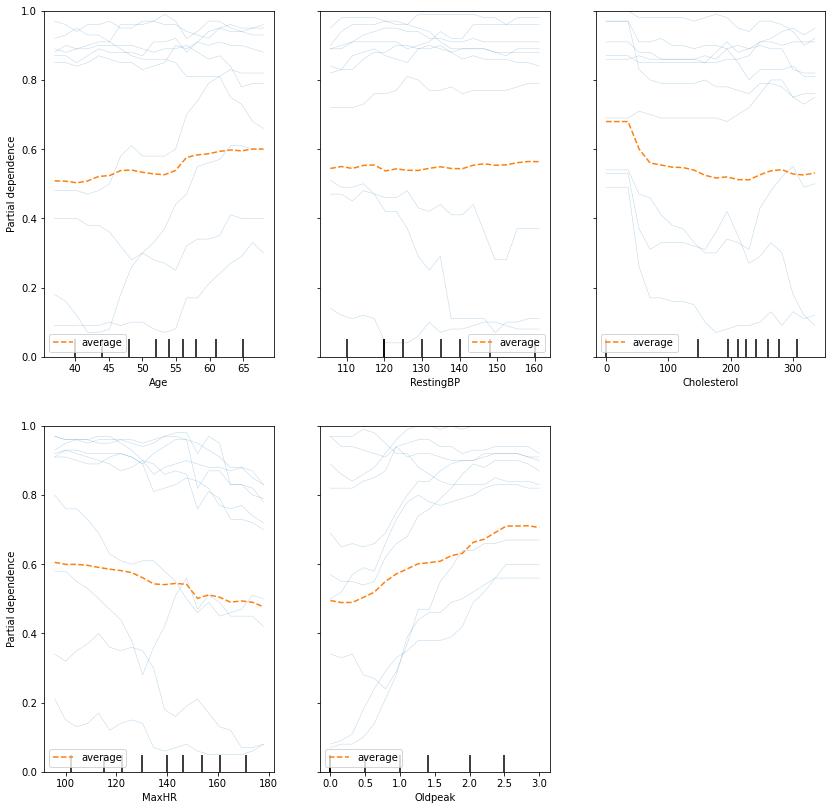

In [5]:
# Train a random forest on training data.
features = data_heart.drop(outcome_name_heart, axis=1)
labels = data_heart[outcome_name_heart]

model = es.RandomForestClassifier(random_state=0)
model = model.fit(features, labels)

num_of_features = 8

fig, ax = plt.subplots(figsize=(14, 14))

display = PartialDependenceDisplay.from_estimator(
       model, features, numeric_features_heart, kind="both", subsample=10,
       n_jobs=3, grid_resolution=20, random_state=0, percentiles = (0.05, 0.95), ax=ax
)

As a proof of concept for our privacy attack, we run the experiment for a few iterations with logging to show how the training data extraction function works in principle.

In [6]:
logger.setLevel(logging.DEBUG)

EXP = ICETDE(data_heart, numeric_features_heart, outcome_name_heart, random_state=0)
EXP.training_data_extraction_experiment(num_queries=10, model=MLPClassifier(random_state=0), model_access=False)

logger.setLevel(logging.INFO)

DEBUG:xai-privacy:Numeric Features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
DEBUG:xai-privacy:Categorical Features: ['CA', 'ChestPainType', 'ExerciseAngina', 'FastingBS', 'RestingECG', 'ST_Slope', 'Sex', 'Thal']
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

DEBUG:xai-privacy:Sample index 0: Shared prediction value: 0.6072013581694548
DEBUG:xai-privacy:Sample index 0: Extracted sample: [ 47.   1.   1. 110. 249.   0.   0. 150.   0.   0.   4.   4.   8.]
DEBUG:xai-privacy:Sample index 1: Shared prediction value: 0.9098260548199899
DEBUG:xai-privacy:Sample index 1: Extracted sample: [ 47.   1.   4. 110. 275.   0.   2. 118.   1.   1.   2.   1.   3.]
DEBUG:xai-privacy:Sample index 2: Shared prediction value: 0.08976656727809494
DEBUG:xai-privacy:Sample index 2: Extracted sample: [ 44.    0.    3.  118.  242.    0.    0.  149.    0.    0.3   2.    1.
   3. ]
DEBUG:xai-privacy:Sample index 3: Shared prediction value: 0.9564565247360133
DEBUG:xai-privacy:Sample index 3: Extracted sample: [ 70.    1.    4.  130.  322.    0.    2.  109.    0.    2.4   2.    3.
   3. ]
DEBUG:xai-privacy:Sample index 4: Shared prediction value: 0.037978481714357686
DEBUG:xai-privacy:Sample index 4: Extracted sample: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.

Total time: 5.27s (training model: 0.94s, training explainer: 4.25s, experiment: 0.09s)
Number of extracted samples: 10
Number of accurate extracted samples: 10
Precision: 1.0, recall: 1.0


The proof of concept shows that training data extraction with ICE can be highly accurate and complete (recall 100%).

Now we begin executing the actual experiment. We begin by defining the table that will hold the results for all our different experiment variations. Then we execute all variations of the experiment for this dataset. We vary the model between a decision tree, a random forest and a neural network. Each model uses the default configuration of scikit-learn.

In [7]:
results_ = {'dataset': [], 'model': [], 'precision': [], 'recall': []}

results = pd.DataFrame(data = results_)

In [8]:
dataset_dicts = [data_heart_dict, data_heart_num_dict, data_heart_cat_dict, data_census_dict, data_census_num_dict, data_census_cat_dict]

dt_dict = {'name': 'decision tree', 'model': DecisionTreeClassifier}
rf_dict = {'name': 'random forest', 'model': es.RandomForestClassifier}
nn_dict = {'name': 'neural network', 'model': MLPClassifier}

model_dicts = [dt_dict, rf_dict, nn_dict]

In [9]:
# This will run the experiment for each dataset and model combination

results = run_all_experiments(ICETDE, dataset_dicts, model_dicts, random_state=0, num_queries=None, model_access=False, threads=1, results_table=results, is_mem_inf=False)

dataset: heart, model: decision tree


  0%|          | 0/826 [00:00<?, ?it/s]

Total time: 3.54s (training model: 0.02s, training explainer: 3.15s, experiment: 0.36s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart, model: random forest


  0%|          | 0/826 [00:00<?, ?it/s]

Total time: 14.03s (training model: 0.18s, training explainer: 13.47s, experiment: 0.39s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.0036319612590799033
dataset: heart, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/826 [00:00<?, ?it/s]

Total time: 5.45s (training model: 0.80s, training explainer: 3.71s, experiment: 0.94s)
Number of extracted samples: 826
Number of accurate extracted samples: 826
Precision: 1.0, recall: 1.0
dataset: heart numeric, model: decision tree


  0%|          | 0/824 [00:00<?, ?it/s]

Total time: 1.40s (training model: 0.01s, training explainer: 1.18s, experiment: 0.21s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart numeric, model: random forest


  0%|          | 0/824 [00:00<?, ?it/s]

Total time: 11.58s (training model: 0.18s, training explainer: 11.07s, experiment: 0.33s)
Number of extracted samples: 3
Number of accurate extracted samples: 3
Precision: 1.0, recall: 0.0036407766990291263
dataset: heart numeric, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/824 [00:00<?, ?it/s]

Total time: 3.75s (training model: 1.14s, training explainer: 2.02s, experiment: 0.60s)
Number of extracted samples: 824
Number of accurate extracted samples: 824
Precision: 1.0, recall: 1.0
dataset: heart categorical, model: decision tree


  0%|          | 0/820 [00:00<?, ?it/s]

Total time: 0.80s (training model: 0.02s, training explainer: 0.41s, experiment: 0.37s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: heart categorical, model: random forest


  0%|          | 0/820 [00:00<?, ?it/s]

Total time: 2.82s (training model: 0.24s, training explainer: 2.08s, experiment: 0.50s)
Number of extracted samples: 132
Number of accurate extracted samples: 132
Precision: 1.0, recall: 0.16097560975609757
dataset: heart categorical, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/820 [00:00<?, ?it/s]

Total time: 2.78s (training model: 1.37s, training explainer: 0.54s, experiment: 0.87s)
Number of extracted samples: 820
Number of accurate extracted samples: 820
Precision: 1.0, recall: 1.0
dataset: census, model: decision tree


  0%|          | 0/26314 [00:00<?, ?it/s]

Total time: 29.44s (training model: 0.93s, training explainer: 18.02s, experiment: 10.49s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census, model: random forest


  0%|          | 0/26314 [00:00<?, ?it/s]

Total time: 270.78s (training model: 17.12s, training explainer: 241.49s, experiment: 12.17s)
Number of extracted samples: 1
Number of accurate extracted samples: 1
Precision: 1.0, recall: 3.800258417572395e-05
dataset: census, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/26314 [00:00<?, ?it/s]

Total time: 152.66s (training model: 40.52s, training explainer: 32.89s, experiment: 79.25s)
Number of extracted samples: 26185
Number of accurate extracted samples: 26185
Precision: 1.0, recall: 0.9950976666413316
dataset: census numeric, model: decision tree


  0%|          | 0/10303 [00:00<?, ?it/s]

Total time: 4.43s (training model: 0.02s, training explainer: 1.73s, experiment: 2.68s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census numeric, model: random forest


  0%|          | 0/10303 [00:00<?, ?it/s]

Total time: 48.97s (training model: 0.73s, training explainer: 45.47s, experiment: 2.77s)
Number of extracted samples: 149
Number of accurate extracted samples: 149
Precision: 1.0, recall: 0.01446180724060953
dataset: census numeric, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/10303 [00:00<?, ?it/s]

Total time: 23.31s (training model: 7.97s, training explainer: 4.20s, experiment: 11.15s)
Number of extracted samples: 10303
Number of accurate extracted samples: 10303
Precision: 1.0, recall: 1.0
dataset: census categorical, model: decision tree


  0%|          | 0/18026 [00:00<?, ?it/s]

Total time: 9.92s (training model: 0.55s, training explainer: 2.63s, experiment: 6.74s)
Number of extracted samples: 0
Number of accurate extracted samples: 0
Precision: nan, recall: 0.0
dataset: census categorical, model: random forest


  0%|          | 0/18026 [00:00<?, ?it/s]

Total time: 64.72s (training model: 8.63s, training explainer: 45.57s, experiment: 10.52s)
Number of extracted samples: 1913
Number of accurate extracted samples: 1913
Precision: 1.0, recall: 0.10612448685232442
dataset: census categorical, model: neural network


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/18026 [00:00<?, ?it/s]

Total time: 74.99s (training model: 27.72s, training explainer: 5.72s, experiment: 41.55s)
Number of extracted samples: 18026
Number of accurate extracted samples: 18026
Precision: 1.0, recall: 1.0


# Results

The results of all variations of the training data extraction experiment with ICE. In each experiment, sample extraction was attempted for each sample in the training data.

Precision measures the precentage of extracted samples that actually appear in the training data.

Recall measures the percentage of training samples that were succesfully extracted by the attack.

In [10]:
results

,dataset,model,precision,recall
0,heart,decision tree,NaN,0.000000
1,heart,random forest,1.0,0.003632
2,heart,neural network,1.0,1.000000
3,heart numeric,decision tree,NaN,0.000000
4,heart numeric,random forest,1.0,0.003641
5,heart numeric,neural network,1.0,1.000000
6,heart categorical,decision tree,NaN,0.000000
7,heart categorical,random forest,1.0,0.160976
8,heart categorical,neural network,1.0,1.000000
9,census,decision tree,NaN,0.000000


In [11]:
results.to_csv('results/2-2-ice-training-data-extraction-results.csv', index=False, na_rep='NaN', float_format='%.3f')

# Discussion

In our experiments, training data extraction with ICE has a recall of 0% for a decision tree, 0% to 15% for a random forest and 100% for a neural network. Since the attack cannot produce any false positive samples, precision is always 100% (when it was measureable, i.e. when any samples were extracted).

The non-existent recall of the decision tree can easily be explained by it's low number of different predictions (only 1 or 0, see discussion of experiment 1.3). This means there can never be an unambiguous extraction from ICE lines if all features have two or more possible feature values. In this situation, one of two cases must occur:

1. The ICE lines share multiple prediction values: This means no unambiguous extraction is possible.

2. They only share one common prediction value, w.l.o.g. 1. This means every line contains the prediction 1 at least once, and at least one line does not contain the prediction 0 (otherwise 0 would also be a common prediction value). This line must only contain the prediction 1 and since it has more than two feature values, it contains the prediction 1 at least at two different values. This means no unambiguous prediction is possible.

Therefore, this training data extraction attack against ICE with a decision tree always has recall 0 if all features have at least two different feature values (this is generally the case, otherwise no information would be conveyed by that feature).

While the number of unique prediction values of a random forest is much higher than a decision tree (69 vs 2, see discussion of 1.3), it is still much lower than that of a neural network (69 vs 3800, see discussion of 1.3). This explains why training data extraction has a much higher recall for a neural network than a random forest. With fewer different prediction values, it becomes more likely that multiple ICE lines have multiple common prediction values or that one prediction value occurs multiple times in an ICE line. Both events can cause the extraction to become impossible due to ambiguity.

However, how do we explain the difference in recall for a random forest between numeric data (0%) and categorical data (15%)? Let's have a look at the number of unique values per feature in the numeric dataset and the categorical dataset:

In [13]:
print('\nUnique values per column in the numeric dataset:')
for col in data_heart_num.columns:
    unique_values = data_heart_num[col].unique()
    print(f'Column {col}: {len(unique_values)}')
    
print('\nUnique values per column in the categorical dataset:')
for col in data_heart_cat.columns:
    unique_values = data_heart_cat[col].unique()
    print(f'Column {col}: {len(unique_values)}')


Unique values per column in the numeric dataset:
Column Age: 50
Column RestingBP: 61
Column Cholesterol: 210
Column MaxHR: 118
Column Oldpeak: 53
Column HeartDisease: 2

Unique values per column in the categorical dataset:
Column Age: 10
Column Sex: 2
Column ChestPainType: 4
Column RestingBP: 8
Column Cholesterol: 10
Column FastingBS: 3
Column RestingECG: 4
Column MaxHR: 10
Column ExerciseAngina: 2
Column Oldpeak: 10
Column ST_Slope: 4
Column CA: 5
Column Thal: 4
Column HeartDisease: 2


We can see that the numeric dataset generally has much more different values per feature than the categorical dataset (as one would expect). In this experiment, each ICE line was made up of the same number of points as there are different values for that feature in the training data. Therefore, if a feature has a large number of different values then its ICE lines will also contain many more values. This means it becomes more likely for one prediction value to occur multiple times and cause ambiguity in the extraction process, thereby making the extraction for that sample impossible. This explains the difference in recall between continous and categorical data well.